#Generic Wastewater Model Testing

##Intro

This is a testing ground for wastewater pipeline containing several modules. Due to unknown dependancies between features as well as correlations we may not be aware of yet, it would be prudent to generate a random dataset and set up a skeleton framework that manipulates the data and runs it through a ML model. These simulations will form the basis of our understanding of how a real pipeline in a plant will look like as well as serve as a convenient tester should we ever get a hold of real sensor data. 

**NOTE** *This pipeline uses randomly generated data so metrics and accuracies will have no applicable meaning. This notebook is simply to test and set up several models that can be readily tested on sensor data when it does arrive for more thorough optimization.*

In [0]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns

The initial exercise is a supervised learning regression problem since we are predicting a continuous value in the form of flow rate or biomass. All features are numeric.
Given an initial input of wastewater data and its output of biomass and exiting flow rate of purified water, our model will be trained and be able to predict the biomass/exit FR of any given instance of these observables.
It should be noted that there are 2 flowrates, the initial speed of wastewater as it enters and is recorded by the sensor and the flow rate of the purified water going out.

We want to maximize exit flow rate (the more purified water produced the better) and biomass (to be converted into more energy by a converter).

##Data Cleaning & Preparation

In [2]:
var = ['biomass (g/L)', 'input_wastewater_flow_rate (L/sec)', 'output_purified_flow_rate', 'temperature (C)', 'pH', 'salinity(mg/L)', 'turbidity (Nephelometric Turbidity Units / NTU)', 'chemical_oxygen_demand/COD (mg/L)', 'total_suspended_solids/TSS (mg/L)' , 'total_dissolved_solids/TDS (mg/L)' , 'heavy_metals (mg/L)' , 'napthenic_acids/NAs (mg/L)']
dict = {}
for i in var:
  dict[i] = random.sample(range(0, 200000), 50)
df = pd.DataFrame(dict)
df

,biomass (g/L),chemical_oxygen_demand/COD (mg/L),heavy_metals (mg/L),input_wastewater_flow_rate (L/sec),napthenic_acids/NAs (mg/L),output_purified_flow_rate,pH,salinity(mg/L),temperature (C),total_dissolved_solids/TDS (mg/L),total_suspended_solids/TSS (mg/L),turbidity (Nephelometric Turbidity Units / NTU)
0,57205,33136,173946,24000,146140,94047,27877,144781,105022,103932,54982,99020
1,25590,47413,168734,161133,120072,36066,109756,62161,62714,107077,182077,68907
2,129138,172673,28424,158451,173420,30599,149519,9107,196210,191865,121825,61881
3,76120,127692,116135,104990,122784,85017,135128,157502,176292,26163,71774,172356
4,83214,184810,166723,1787,62790,95749,130783,48929,20246,191321,129189,175707
5,161099,169761,143814,165448,50863,139236,108190,93893,142844,151638,44060,119047
6,169654,66043,84824,141537,58039,134991,156921,11516,115884,89742,188167,33712
7,71504,105123,158616,134209,186381,53886,160075,183859,96676,50357,86922,174288
8,38305,88704,799,23032,59966,105750,33992,170846,4569,184049,47902,53511
9,36264,2926,169384,125091,138127,93344,109515,199097,42743,78914,130272,153552


In [3]:
df.keys()

Index(['biomass (g/L)', 'chemical_oxygen_demand/COD (mg/L)',
       'heavy_metals (mg/L)', 'input_wastewater_flow_rate (L/sec)',
       'napthenic_acids/NAs (mg/L)', 'output_purified_flow_rate', 'pH',
       'salinity(mg/L)', 'temperature (C)',
       'total_dissolved_solids/TDS (mg/L)',
       'total_suspended_solids/TSS (mg/L)',
       'turbidity (Nephelometric Turbidity Units / NTU)'],
      dtype='object')

In [0]:
train_df = df.sample(frac=0.8,random_state=0) 
test_df = df.drop(train_df.index)

Seen above this is our test dataset that we will be playing with. As mentioned before these values are purely random placeholders (a pH level of 9828 is literally impossible) and their real-life implications are to be ignored.
Also above are our training and test datasets with a 80/20 split. Below, we take a quick peek at the general statistics of our training data as well as graph its form. Useful for a pre-training understanding of our data. As the data is random, these stats/graphs don't mean anything at the moment.

We separate the biomass feature from the data set as this is what we want our model to predict.

In [5]:
train_stats = train_df.describe()
train_stats.pop('biomass (g/L)')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
chemical_oxygen_demand/COD (mg/L),40.0,106802.350,61918.061253,3664.0,52350.00,104743.5,162917.25,199257.0
heavy_metals (mg/L),40.0,110423.100,55112.137768,799.0,80993.00,114297.0,155669.25,196090.0
input_wastewater_flow_rate (L/sec),40.0,114716.500,57450.416746,1787.0,63405.50,137110.5,161133.75,195508.0
napthenic_acids/NAs (mg/L),40.0,100402.900,56055.561205,15092.0,45277.75,103619.5,150326.50,186381.0
output_purified_flow_rate,40.0,94877.750,54257.860202,3999.0,36672.00,103947.5,139750.25,196425.0
pH,40.0,111566.950,58323.746825,4264.0,55980.50,123743.0,156589.50,198163.0
salinity(mg/L),40.0,110443.750,64217.271960,618.0,53399.00,123114.5,168143.75,198362.0
temperature (C),40.0,92825.050,65065.812267,1598.0,34601.75,97813.0,148094.00,196210.0
total_dissolved_solids/TDS (mg/L),40.0,116263.000,59830.388866,6246.0,70618.25,120617.0,164296.00,199956.0
total_suspended_solids/TSS (mg/L),40.0,109524.975,58978.852758,874.0,65443.25,121250.0,153922.00,199868.0


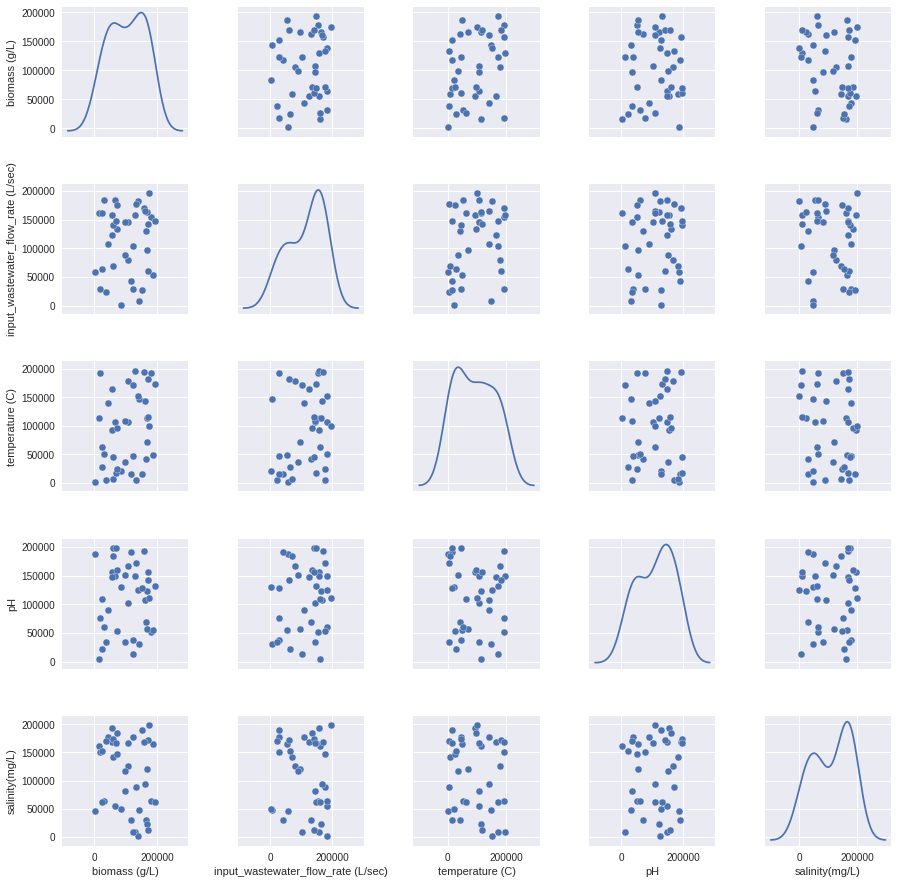

In [6]:
sns.pairplot(train_df[['biomass (g/L)', 'input_wastewater_flow_rate (L/sec)', 'temperature (C)', 'pH', 'salinity(mg/L)']], diag_kind="kde")

In [0]:
train_labels = train_df.pop('biomass (g/L)')
test_labels = test_df.pop('biomass (g/L)') #removes biomass from our inputs as that is our predicted label

In [8]:
def norm(x):
  '''
  Normalizes our training values as several features have different ranges and scalings. It is good practice anyway and helps the model along.
  
  '''
  return (x - train_stats['mean']) / train_stats['std']
normalized_train_data = norm(train_df)
normalized_test_data = norm(test_df)
normalized_train_data

,chemical_oxygen_demand/COD (mg/L),heavy_metals (mg/L),input_wastewater_flow_rate (L/sec),napthenic_acids/NAs (mg/L),output_purified_flow_rate,pH,salinity(mg/L),temperature (C),total_dissolved_solids/TDS (mg/L),total_suspended_solids/TSS (mg/L),turbidity (Nephelometric Turbidity Units / NTU)
28,-1.422079,-0.890132,0.757619,0.796444,0.917365,0.770047,1.299234,-0.003935,0.811444,1.078472,-1.170066
11,0.583669,0.297700,0.677010,1.171803,0.710556,-1.014886,-0.725206,1.520076,0.355371,-0.175401,0.831226
10,-0.527057,1.007653,0.280773,1.074614,-0.668452,-0.720529,-1.258256,-0.796010,-0.683532,0.723226,-1.051996
41,-1.573731,-0.742542,-1.870126,0.008707,1.265222,-1.377568,-0.972320,0.829083,-1.838815,-0.573917,-0.890834
2,1.063836,-1.487859,0.761256,1.302584,-1.184690,0.650714,-1.578030,1.588929,1.263605,0.208550,-0.606922
27,0.692652,0.209281,-0.969697,-1.049082,1.093597,1.296865,-0.996395,-1.402073,1.398838,-0.396803,-1.383222
38,0.850376,1.554411,-0.618612,-0.023832,-1.095173,0.960244,0.238740,1.304371,-1.184081,-1.298126,-0.750066
31,1.493177,1.511607,-1.247850,0.407258,-1.223947,1.349623,-1.267973,-1.181128,-0.155289,1.125166,-0.715894
22,-1.665723,-0.138447,0.807992,-1.122260,-0.554440,-1.839781,0.795756,0.306504,-0.905861,-0.361705,0.347404
4,1.259853,1.021552,-1.965686,-0.670993,0.016058,0.329472,-0.957916,-1.115471,1.254513,0.333408,1.411607


##The ML Model

To start off we'll use the simplest  linear Neural Network model with the Sequential builder.  Using the summary in-built function, we can take a closer look at it's details and layers.
Our loss function is mean squared error and activation function is Tensorflows own ReLU.

In [0]:
def build_biomass_predictor_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_df.keys())]), #first layer that takes in the shape of our training dataframe
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [10]:
model = build_biomass_predictor_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                768       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,993
Trainable params: 4,993
Non-trainable params: 0
_________________________________________________________________


We can run a quick sample batch just to make sure it is running without errors and it is giving us something we expect in the shape that we want.

In [11]:
sample_batch = normalized_train_data[:10]
sample_test_result = model.predict(sample_batch)
sample_test_result

array([[ 0.01565186],
       [-0.14190713],
       [-0.05954042],
       [ 0.12920865],
       [ 0.01494243],
       [ 0.17679274],
       [-0.36011437],
       [-0.24186826],
       [ 0.25752652],
       [-0.33123899]], dtype=float32)

In [12]:
train_the_model = model.fit(normalized_train_data, train_labels, epochs=100, validation_split = 0.2)

Train on 32 samples, validate on 8 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
32/32 [==============================] - 0s 8ms/sample - loss: 13772476416.0000 - mean_absolute_error: 103299.0312 - mean_squared_error: 13772476416.0000 - val_loss: 14159089664.0000 - val_mean_absolute_error: 104688.5156 - val_mean_squared_error: 14159089664.0000
Epoch 2/100
32/32 [==============================] - 0s 158us/sample - loss: 13772421120.0000 - mean_absolute_error: 103298.7500 - mean_squared_error: 13772421120.0000 - val_loss: 14159050752.0000 - val_mean_absolute_error: 104688.3281 - val_mean_squared_error: 14159050752.0000
Epoch 3/100
32/32 [==============================] - 0s 147us/sample - loss: 13772379136.0000 - mean_absolute_error: 103298.5469 - mean_squared_error: 13772379136.0000 - val_loss: 14159015936.0000 - val_mean_absolute_error: 104688.1562 - val_mean_squared_error: 14159015936.0000
Epoch 4/100
32/32 [==============================] - 0s 182us/sample - los

Our training gave us alot of results. But its a bit messy. We can check it's history in a dataframe for better examination. 
We create the epoch column so we know which result matches which instance of the training cycle.

In [13]:
hist = pd.DataFrame(train_the_model.history)
hist['epoch'] = train_the_model.epoch
hist.tail()
hist

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
0,1.377248e+10,103299.031250,1.377248e+10,1.415909e+10,104688.515625,1.415909e+10,0
1,1.377242e+10,103298.750000,1.377242e+10,1.415905e+10,104688.328125,1.415905e+10,1
2,1.377238e+10,103298.546875,1.377238e+10,1.415902e+10,104688.156250,1.415902e+10,2
3,1.377234e+10,103298.359375,1.377234e+10,1.415898e+10,104687.992188,1.415898e+10,3
4,1.377231e+10,103298.187500,1.377231e+10,1.415895e+10,104687.843750,1.415895e+10,4
5,1.377228e+10,103298.031250,1.377228e+10,1.415892e+10,104687.695312,1.415892e+10,5
6,1.377224e+10,103297.867188,1.377224e+10,1.415889e+10,104687.539062,1.415889e+10,6
7,1.377221e+10,103297.710938,1.377221e+10,1.415886e+10,104687.398438,1.415886e+10,7
8,1.377218e+10,103297.562500,1.377218e+10,1.415883e+10,104687.257812,1.415883e+10,8
9,1.377215e+10,103297.406250,1.377215e+10,1.415880e+10,104687.117188,1.415880e+10,9


(0, 10000000000000000)

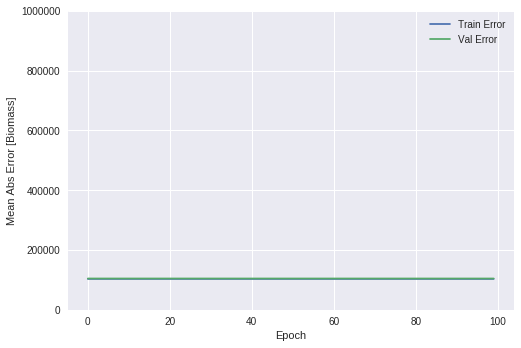

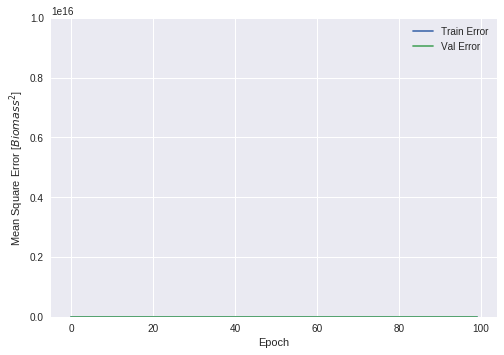

In [35]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error [Biomass]')
plt.plot(hist['epoch'], hist['mean_absolute_error'],
         label='Train Error')
plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
         label = 'Val Error')
plt.legend()
plt.ylim([0,1000000])

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error [$Biomass^2$]')
plt.plot(hist['epoch'], hist['mean_squared_error'],
         label='Train Error')
plt.plot(hist['epoch'], hist['val_mean_squared_error'],
         label = 'Val Error')
plt.legend()
plt.ylim([0,10000000000000000])

The last cell is set up so that we can graph our mean squared error and mean absolute error to evaluate our model's perfomance and help us make decisions for optimization after. There no plots currently due our random numbers not producing anything of value. 